In [317]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.fourier import circuit_spectrum
from lecture08_helpers import *

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

<h1>
    VQC from Pennylane Tutorial
</h1>

In [318]:
np.random.seed(42)

def square_loss(targets, predictions):
    loss = 0
    for t, p in zip(targets, predictions):
        loss += (t - p) ** 2
    loss = loss / len(targets)
    return 0.5*loss

In [319]:
degree = 1  # degree of the target function
scaling = 1  # scaling of the data
coeffs = [0.15 + 0.15j]*degree  # coefficients of non-zero frequencies
coeff0 = 0.1  # coefficient of zero frequency

def target_function(x):
    """Generate a truncated Fourier series, where the data gets re-scaled."""
    res = coeff0
    for idx, coeff in enumerate(coeffs):
        exponent = np.complex128(scaling * (idx+1) * x * 1j)
        conj_coeff = np.conjugate(coeff)
        res += coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent)
    return np.real(res)

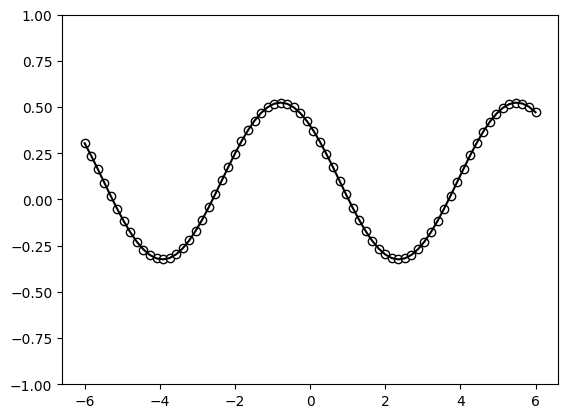

In [320]:
x = np.linspace(-6, 6, 70, requires_grad=False)
# x = np.linspace(-6, 6, 10, requires_grad=False)
target_y = np.array([target_function(x_) for x_ in x], requires_grad=False)

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.ylim(-1, 1)
plt.show()

In [321]:
scaling = 1
dev = qml.device('default.qubit', wires=1)

def S(x):
    """Data-encoding circuit block."""
    qml.RX(scaling * x, wires=0, id="x0")

def W(theta):
    """Trainable circuit block."""
    qml.Rot(theta[0], theta[1], theta[2], wires=0)

@qml.qnode(dev, interface="autograd")
def serial_quantum_model(weights, x):

    for theta in weights[:-1]:
        W(theta)
        S(x)

    # (L+1)'th unitary
    W(weights[-1])

    return qml.expval(qml.PauliZ(wires=0))


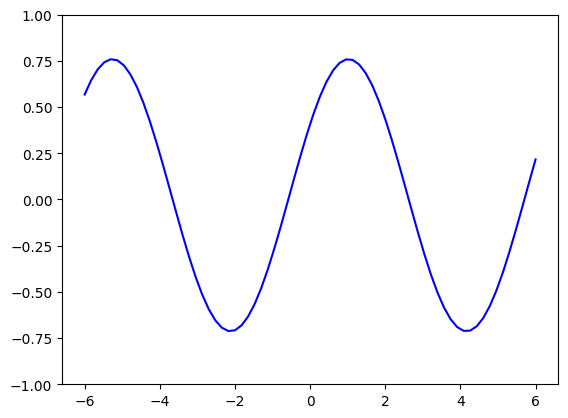

In [322]:
r = 1 # number of times the encoding gets repeated (here equal to the number of layers)
weights = 2 * np.pi * np.random.random(size=(r+1, 3), requires_grad=True) # some random initial weights

x = np.linspace(-6, 6, 70, requires_grad=False)
# x = np.linspace(-6, 6, 10, requires_grad=False)
random_quantum_model_y = [serial_quantum_model(weights, x_) for x_ in x]

plt.plot(x, random_quantum_model_y, c='blue')
plt.ylim(-1,1)
plt.show()

In [323]:
print(qml.draw(serial_quantum_model)(weights, x[-1]))

0: ──Rot(2.35,5.97,4.60)──RX(6.00)──Rot(3.76,0.98,0.98)─┤  <Z>


In [324]:
def cost(weights, x, y):
    predictions = [serial_quantum_model(weights, x_) for x_ in x]
    return square_loss(y, predictions)

max_steps = 50
opt = qml.AdamOptimizer(0.3)
batch_size = 25
cst = [cost(weights, x, target_y)]  # initial cost

for step in range(max_steps):

    # Select batch of data
    batch_index = np.random.randint(0, len(x), (batch_size,))
    x_batch = x[batch_index]
    y_batch = target_y[batch_index]

    # Update the weights by one optimizer step
    weights, _, _ = opt.step(cost, weights, x_batch, y_batch)

    # Save, and possibly print, the current cost
    c = cost(weights, x, target_y)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

Cost at step  10: 0.032120417200045624
Cost at step  20: 0.013853561883024756
Cost at step  30: 0.004049396436389454
Cost at step  40: 0.0005624933894468386
Cost at step  50: 8.145777333270847e-05


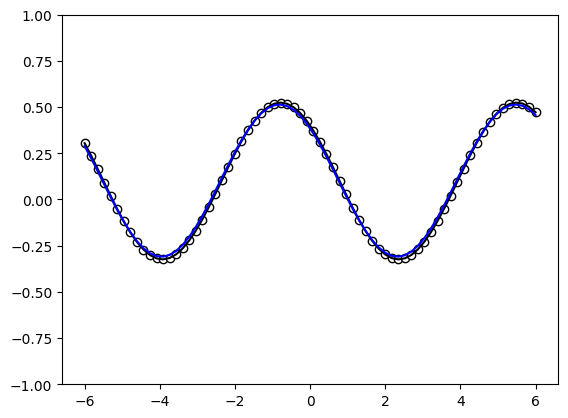

In [325]:
predictions = [serial_quantum_model(weights, x_) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='blue')
plt.ylim(-1,1)
plt.show()

<img src="pics/RFF1-steps.png" width="480" height="240"/>


<h2>
    Step 2: Use all eigenvalues to obtain the frequencies
</h2>

<img src="pics/eq4.png" width="480" height="240"/>
<img src="pics/eq5.png" width="480" height="240"/>

In [327]:
freqs = circuit_spectrum(serial_quantum_model)(weights, x)
for k, v in freqs.items():
    print(k, ":", v)

print(freqs)

x0 : [-1.0, 0, 1.0]
{'x0': [-1.0, 0, 1.0]}


In [328]:
# Step 3: Sample D frequencies
D = 3
sampled_freqs = freqs
temp = np.array(D)

In [329]:
'''
for a single x, y pair, the kernel function looks like:
    phi(y).T --> [
                      1/sqrt(D) * cos(omega1.T * y), 1/sqrt(D) * cos(omega2.T * y), 1/sqrt(D) * cos(omega3.T * y),
                      1/sqrt(D) * sin(omega1.T * y), 1/sqrt(D) * sin(omega2.T * y), 1/sqrt(D) * sin(omega3.T * y)                  
                  ]
    
    phi(x)   --> [
                    1/sqrt(D) * cos(omega1.T * x), 1/sqrt(D) * cos(omega2.T * x), 1/sqrt(D) * cos(omega3.T * x)
                    1/sqrt(D) * sin(omega1.T * x), 1/sqrt(D) * sin(omega2.T * x), 1/sqrt(D) * sin(omega3.T * x)
                  ]
                  
    phi(x).T --> [
                    1/sqrt(D) * cos(omega1.T * x), 1/sqrt(D) * sin(omega1.T * x),
                    1/sqrt(D) * cos(omega2.T * x), 1/sqrt(D) * sin(omega2.T * x),
                    1/sqrt(D) * cos(omega3.T * x), 1/sqrt(D) * sin(omega3.T * x)
                  ]
                  
    k(x, y) = phi(y).T * phi(x).T  --> [something + something]
'''


# Step 4: Construct the approximated kernel
# We think that we don't need to construct a kernel function
# def phi_tilde(x, sampled_freq):
#     empty = np.zeros((D, 2))
#     for i in range(D):
#         empty[i][0] = 1/np.sqrt(D) * np.cos(sampled_freq[i] * x)
#         empty[i][1] = 1/np.sqrt(D) * np.sin(sampled_freq[i] * x)
#     return empty

'\nfor a single x, y pair, the kernel function looks like:\n    phi(y).T --> [\n                      1/sqrt(D) * cos(omega1.T * y), 1/sqrt(D) * cos(omega2.T * y), 1/sqrt(D) * cos(omega3.T * y),\n                      1/sqrt(D) * sin(omega1.T * y), 1/sqrt(D) * sin(omega2.T * y), 1/sqrt(D) * sin(omega3.T * y)                  \n                  ]\n    \n    phi(x)   --> [\n                    1/sqrt(D) * cos(omega1.T * x), 1/sqrt(D) * cos(omega2.T * x), 1/sqrt(D) * cos(omega3.T * x)\n                    1/sqrt(D) * sin(omega1.T * x), 1/sqrt(D) * sin(omega2.T * x), 1/sqrt(D) * sin(omega3.T * x)\n                  ]\n                  \n    phi(x).T --> [\n                    1/sqrt(D) * cos(omega1.T * x), 1/sqrt(D) * sin(omega1.T * x),\n                    1/sqrt(D) * cos(omega2.T * x), 1/sqrt(D) * sin(omega2.T * x),\n                    1/sqrt(D) * cos(omega3.T * x), 1/sqrt(D) * sin(omega3.T * x)\n                  ]\n                  \n    k(x, y) = phi(y).T * phi(x).T  --> [somethin

<img src="pics/weights.png" width="360" height="240"/>
<img src="pics/phi_x.png" width="480" height="360"/>

In [330]:
# def approximate_f(x):
#     return phi_tilde(x)

# for i in range(len(x)):
#     print(approximate_f(x))

<h1>
    VQC from Lecture Demo
</h1>

In [331]:
n_samples = 100

X, y = make_blobs(
    n_samples=n_samples, 
    centers=[[0.1, 0.2], [0.25, 0.4]], 
    cluster_std=0.05, 
    n_features=2,
    random_state=6
)

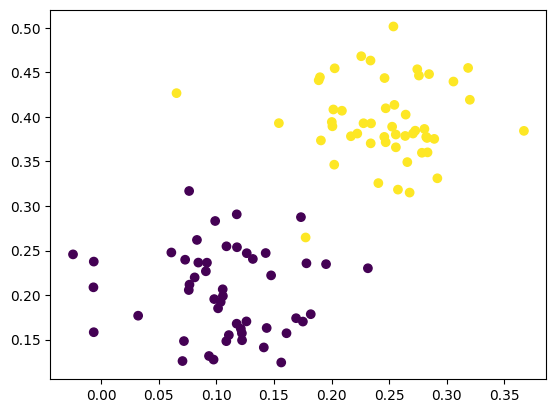

In [332]:
plot_data(X, y)

In [333]:
X = np.array(X, requires_grad=False)
y = np.array(y, requires_grad=False)
y[y == 0] = -1

In [334]:
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def model_2(point, weights):
    qml.AngleEmbedding(point, wires=[0, 1])
    qml.Rot(*weights[0], wires=0)
    qml.Rot(*weights[1], wires=1)
    qml.CNOT(wires=[1, 0])
    return qml.expval(qml.PauliX(0))

In [335]:
weights = np.random.normal(size=(2, 3), requires_grad=True)
weights

tensor([[ 0.69476103, -1.0608268 , -3.48080883],
        [-0.87022324,  1.20562808,  0.34313505]], requires_grad=True)

In [336]:
print(qml.draw(model_2, expansion_strategy="device")(X[0], weights))

0: ──RX(0.12)──Rot(0.69,-1.06,-3.48)─╭X─┤  <X>
1: ──RX(0.25)──Rot(-0.87,1.21,0.34)──╰●─┤     


In [337]:
loss = make_loss_function(X, y, model_2)

In [338]:
# opt = qml.GradientDescentOptimizer(stepsize=0.1)

# n_its = 100

# loss_track = []

# for it in range(n_its):
#     weights, _loss = opt.step_and_cost(loss, weights)
#     if it % 5 == 0:
#         our_preds = make_predictions(X, model_2, weights)
#         print(f"Loss at iteration {it} = {_loss}  Accuracy = {compute_accuracy(our_preds, y)}")
#     loss_track.append(_loss)

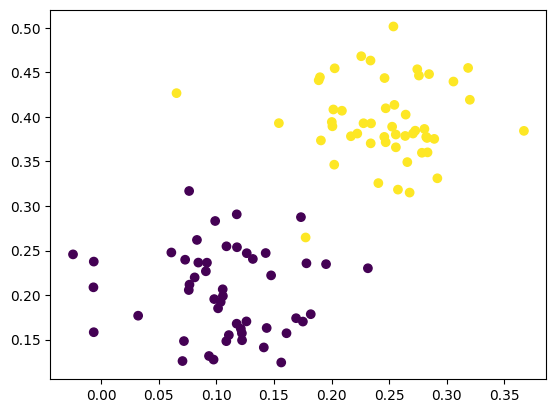

In [339]:
our_preds = make_predictions(X, model_2, weights)
plot_data(X, y)

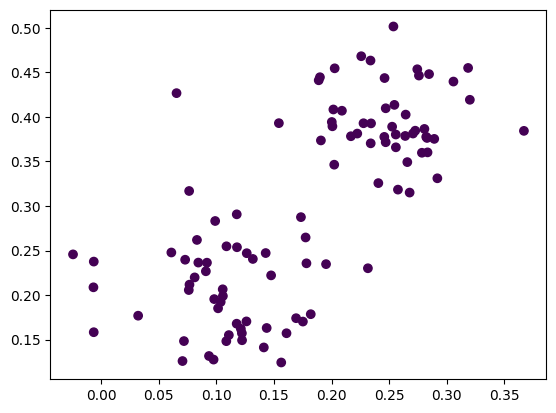

In [340]:
plot_data(X, our_preds)

In [341]:
compute_accuracy(our_preds, y)

0.5

<h1>
    Demo
</h1>

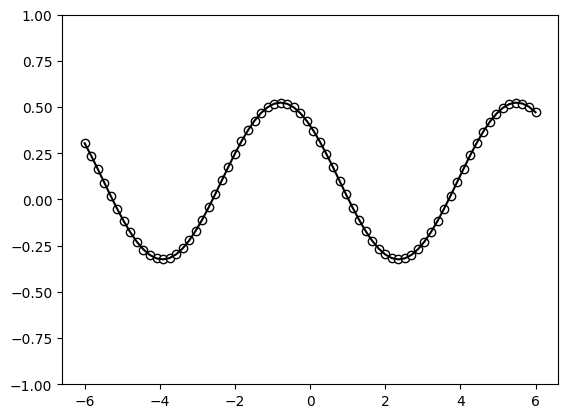

In [342]:
# This part of the code prints the graph we are trying to approximate

degree = 1  # degree of the target function
scaling = 1  # scaling of the data
coeffs = [0.15 + 0.15j]*degree  # coefficients of non-zero frequencies
coeff0 = 0.1  # coefficient of zero frequency

def target_function(x):
    """Generate a truncated Fourier series, where the data gets re-scaled."""
    res = coeff0
    for idx, coeff in enumerate(coeffs):
        exponent = np.complex128(scaling * (idx+1) * x * 1j)
        conj_coeff = np.conjugate(coeff)
        res += coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent)
    return np.real(res)

x = np.linspace(-6, 6, 70)
target_y = np.array([target_function(x_) for x_ in x])


plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.ylim(-1, 1)
plt.show()

In [343]:
#This is a VQC that changes based on the input n_layers which changes how many frequencies we can sample.

import pennylane as qml
import numpy as np

n_layers = 2
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def circuit(x, weights):
    for l in range(n_layers):
        qml.RX(x, wires=0, id="x"+str(0))
        qml.Rot(weights[l,0,0], weights[l,0,1], weights[l,0,2], wires=0)
    qml.RZ(x, wires=0, id="x0")
    return qml.expval(qml.PauliZ(wires=0))

x = 1
weights = np.random.random((n_layers, 1, 3))
res = qml.fourier.circuit_spectrum(circuit)(x, weights)

print(qml.draw(circuit)(x, weights))
for inp, freqs in res.items():
    print(f"{inp}: {freqs}")


0: ──RX(1.00)──Rot(0.35,0.68,0.57)──RX(1.00)──Rot(0.27,0.88,0.80)──RZ(1.00)─┤  <Z>
x0: [-3.0, -2.0, -1.0, 0, 1.0, 2.0, 3.0]


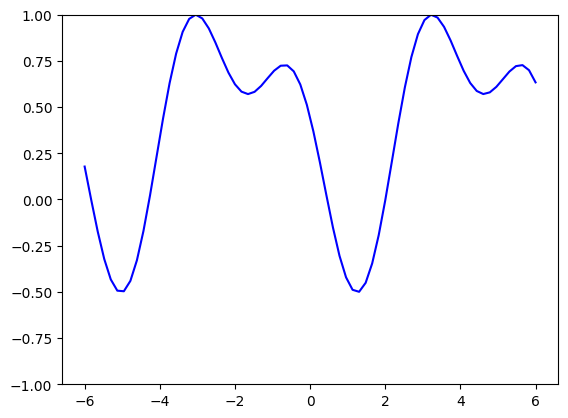

In [344]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.fourier import circuit_spectrum
from lecture08_helpers import *

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

r = 1 # number of times the encoding gets repeated (here equal to the number of layers)
weights = np.random.random((n_layers, 1, 3), requires_grad=True) # some random initial weights

x = np.linspace(-6, 6, 70)
# x = np.linspace(-6, 6, 10, requires_grad=False)
random_quantum_model_y = [circuit(x_, weights) for x_ in x]

plt.plot(x, random_quantum_model_y, c='blue')
plt.ylim(-1,1)
plt.show()

In [353]:
def cost(weights, x, y):
    predictions = [circuit(x_, weights) for x_ in x]
    return square_loss(y, predictions)

max_steps = 200
opt = qml.AdamOptimizer(0.3)
batch_size = 25
cst = [cost(weights, x, target_y)]  # initial cost

for step in range(max_steps):

    # Select batch of data
    batch_index = np.random.randint(0, len(x), (batch_size,))
    x_batch = x[batch_index]
    y_batch = target_y[batch_index]

    # Update the weights by one optimizer step
    weights, _, _ = opt.step(cost, weights, x_batch, y_batch)

    # Save, and possibly print, the current cost
    c = cost(weights, x, target_y)
    cst.append(c)
    if (step + 1) % 10 == 0:
        print("Cost at step {0:3}: {1}".format(step + 1, c))

Cost at step  10: 0.023787598896472056
Cost at step  20: 0.005836115073786111
Cost at step  30: 0.0012728892531842237
Cost at step  40: 0.00033625474789329815
Cost at step  50: 0.0008560354936985901
Cost at step  60: 0.00024326579505671724
Cost at step  70: 0.00024733248418931794
Cost at step  80: 5.812876587959553e-05
Cost at step  90: 0.0001126763736095692
Cost at step 100: 0.00016047573213027723
Cost at step 110: 7.253625041815489e-05
Cost at step 120: 5.935372535173037e-05
Cost at step 130: 3.7404037785183575e-05
Cost at step 140: 3.1985353104981486e-05
Cost at step 150: 1.6992815501593513e-05
Cost at step 160: 3.089869338051865e-05
Cost at step 170: 1.181600300685261e-05
Cost at step 180: 1.4479278959781252e-05
Cost at step 190: 2.47952719717222e-05
Cost at step 200: 2.657679474438175e-05


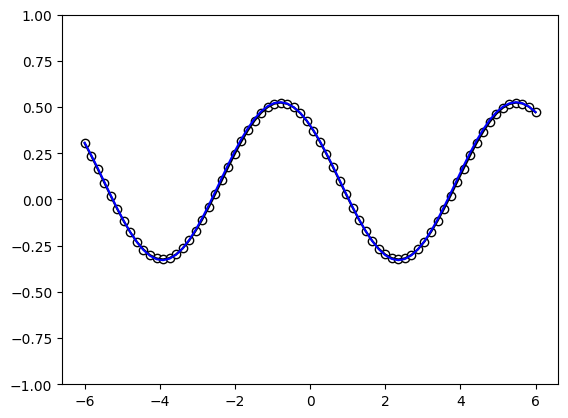

In [354]:
predictions = [circuit(x_, weights) for x_ in x]

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.plot(x, predictions, c='blue')
plt.ylim(-1,1)
plt.show()

In [347]:
#The gates are RX but you are trying to diagonalize Paulix and Pauliz
def encoding_eigvals(x):
    rxEigvalOne = qml.eigvals(qml.PauliX(wires=0))/2
    rxEigvalTwo = qml.eigvals(qml.PauliX(wires=0))/2
    rzEigval = qml.eigvals(qml.PauliZ(wires=0))/2
    
    return rxEigvalOne, rxEigvalTwo, rzEigval

x = 1
rxEigvalOne, rxEigvalTwo, rzEigval = encoding_eigvals(x)

#Create an array of all possible combinations of the eigenvalues
upperCaseLambdaArray = []
for eigValOne in rxEigvalOne:
    for eigValTwo in rxEigvalTwo:
        for eigValThree in rzEigval:
            upperCaseLambdaArray.append(eigValOne+eigValTwo+eigValThree)

#Create an array of all possible frequency values stored in OmegaArray
OmegaArray = []
for upperCaseLambdai in upperCaseLambdaArray:
    for upperCaseLambdaj in upperCaseLambdaArray:
        OmegaArray.append(upperCaseLambdai-upperCaseLambdaj)

#Create an new array of unique frequency values stored in OmegaArray
OmegaArray = np.unique(OmegaArray)

print(OmegaArray)

[-3. -2. -1.  0.  1.  2.  3.]


In [348]:
#Helper function to create a range of floats for Algorithm 3
def range_with_floats(start, stop, step):
    while stop >= start:
        yield start
        start += step

#Algorithim 3
#Number of layers
n_layers = 2

#For the circuit we use with each algorithm the number of encoding gates is number of layers + 1
#This is because we have one additional encoding gate RZ.
numberOfEncodingGates = n_layers + 1

#Because the eigenvalues of PauliX and PauliZ gates are -0.5 and 0.5 we know that w_max is numberOfEncodingGates
wMax = numberOfEncodingGates

#We need to assign a step value a resonable step value is anywhere from 0 to 1
step = 1

grid = []

#Create the grid
for i in range_with_floats(0, wMax, step):
    grid.append(i)

print(grid)


[0, 1, 2, 3]


#Construction of Approximation


In [349]:
def construct_phi(x, frequencies):
  #constructs phi or tilde_phi 
  #based on x and the given frequencies

  phi = np.zeros(2* len(frequencies))
  for i in range(len(frequencies)):
    phi[2*i] = np.cos(frequencies[i] * x)
    phi[2*i+1] = np.sin(frequencies[i] * x)
  
  return phi

def construct_Phi(xi_array, frequencies):
  M = len(xi_array)
  P = 2*len(frequencies)
  Phi = np.zeros((M, P))

  for i in range(M):
    phi = construct_phi(xi_array[i], frequencies)
    for j in range(P):
      Phi[i][j] = phi[j]
  return Phi

def construct_w(xi_array, yi_array, frequencies):
  M = len(xi_array)
  P = 2*len(frequencies)
  Phi = construct_Phi(xi_array, frequencies)
  lambda_hyper = 0.001

  Phi_T = np.transpose(Phi)

  w_1 = np.matmul(Phi_T, Phi) + M*lambda_hyper * np.identity(P)
  w_2 = np.matmul(np.linalg.inv(w_1), Phi_T)
  w = np.matmul(w_2, yi_array)
  return w

def f(x, w, frequencies):
  phi = construct_phi(x, frequencies)
  return np.matmul(w, phi)

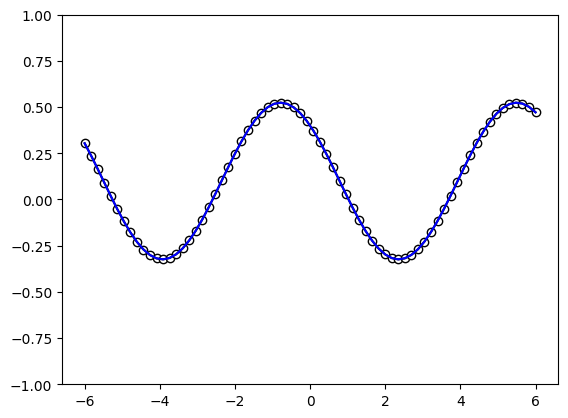

In [352]:
degree = 1  # degree of the target function
scaling = 1  # scaling of the data
coeffs = [0.15 + 0.15j]*degree  # coefficients of non-zero frequencies
coeff0 = 0.1  # coefficient of zero frequency

def target_function(x):
    """Generate a truncated Fourier series, where the data gets re-scaled."""
    res = coeff0
    for idx, coeff in enumerate(coeffs):
        exponent = np.complex128(scaling * (idx+1) * x * 1j)
        conj_coeff = np.conjugate(coeff)
        res += coeff * np.exp(exponent) + conj_coeff * np.exp(-exponent)
    return np.real(res)

x = np.linspace(-6, 6, 70)
target_y = np.array([target_function(x_) for x_ in x])

frequencies = OmegaArray
xi_array = x
yi_array = target_y
w = construct_w(xi_array, yi_array, frequencies)

target_y_f = np.array([f(x_, w, frequencies) for x_ in x])

plt.plot(x, target_y, c='black')
plt.scatter(x, target_y, facecolor='white', edgecolor='black')
plt.ylim(-1, 1)

plt.plot(x, target_y_f, c='blue')
plt.show()